<a href="https://colab.research.google.com/github/illia-nest/automatic-public-discourse-analysis/blob/main/Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D, Concatenate, Dropout, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [8]:
cols = ['text', 'party', 'cmp_code']

data = (pd.read_csv(r'/content/drive/MyDrive/AutoPDA/data_manifesto_corpus_2017-2_english.csv', low_memory=False)
    .filter(items=cols)
    .assign(domain=lambda df: df.cmp_code.astype(str).str.split('').str[1])
    .reindex(columns=[*cols, 'domain'])
    .rename(columns={
        'text' : 'phrase',
        'cmp_code' : 'subdomain'
    })
    .loc[lambda df: df['subdomain'].str.len() == 3]
    .loc[lambda df: df['subdomain'] != '000'])
data.head()

,phrase,party,subdomain,domain
0,The year 2014 is a crucial year in the history...,181210,601,6
1,It is crucial because it marks exactly 20 year...,181210,202,2
2,It is also a crucial year because the dawn of ...,181210,305,3
3,South Africa is supposed to be celebrating 20 ...,181210,201,2
4,"20 years later, black people are still trapped...",181210,503,5


In [9]:
# Tokenize and pad the phrases, reshape data
phases_for_tokenization = data['phrase'].astype(str)
max_len = 60
max_words = 50
tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
tokenizer.fit_on_texts(phases_for_tokenization)
sequences = tokenizer.texts_to_sequences(phases_for_tokenization)
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [10]:
Y = data.domain
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.values.reshape(-1, 1))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [12]:
X_train

array([[  136,   231,     4, ...,     0,     0,     0],
       [ 1336,     2,   103, ...,     0,     0,     0],
       [    3,    10,    18, ...,     0,     0,     0],
       ...,
       [  471,     2,  3315, ...,     0,     0,     0],
       [  363, 18430,   211, ...,     0,     0,     0],
       [   75,    29,     5, ...,     0,     0,     0]], dtype=int32)

In [13]:
Y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [14]:
# One-hot encoding parties, finishing data transformation.
# encoder = OneHotEncoder(sparse_output=False)
# party_one_hot = encoder.fit_transform(data.party.values.reshape(-1, 1))

# one_hot_series = pd.Series([one_hot.tolist() for one_hot in party_one_hot])

In [17]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(128,name='FC2')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(7,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [18]:
tf.keras.backend.clear_session()
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 50)            2500      
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 128)               32896 

In [21]:
history = model.fit(X_train,Y_train,epochs=20, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/20
1801/1801 [==============================] - 18s 10ms/step - loss: 0.3722 - accuracy: 0.3291 - val_loss: 0.3726 - val_accuracy: 0.3341
Epoch 2/20
1801/1801 [==============================] - 18s 10ms/step - loss: 0.3722 - accuracy: 0.3291 - val_loss: 0.3732 - val_accuracy: 0.3339
Epoch 3/20
1801/1801 [==============================] - 18s 10ms/step - loss: 0.3722 - accuracy: 0.3292 - val_loss: 0.3734 - val_accuracy: 0.3341
Epoch 4/20
1801/1801 [==============================] - 18s 10ms/step - loss: 0.3721 - accuracy: 0.3292 - val_loss: 0.3734 - val_accuracy: 0.3341
Epoch 5/20
1801/1801 [==============================] - 24s 13ms/step - loss: 0.3721 - accuracy: 0.3291 - val_loss: 0.3734 - val_accuracy: 0.3341
Epoch 6/20
1801/1801 [==============================] - 30s 17ms/step - loss: 0.3720 - accuracy: 0.3292 - val_loss: 0.3740 - val_accuracy: 0.3340
Epoch 7/20
1801/1801 [==============================] - 27s 15ms/step - loss: 0.3720 - accuracy: 0.3292 - val_loss: 0.3740 -

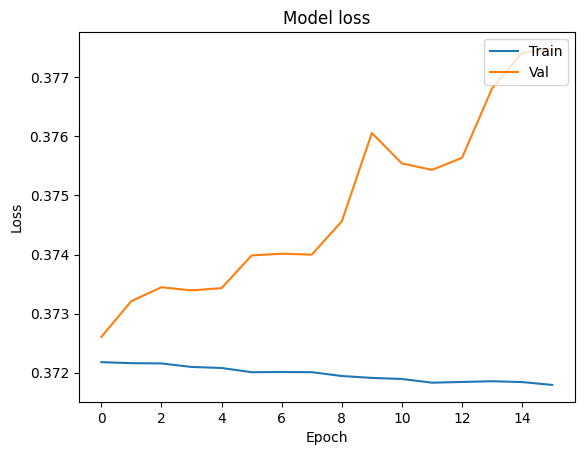

In [22]:
#Visualize the models loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [24]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

398/398 [==============================] - 2s 5ms/step - loss: 0.3746 - accuracy: 0.3372
Test set
 Loss: 0.375
 Accuracy: 0.337


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=32, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, np.argmax(Y_train, axis=1))
Y_pred_rf = rnd_clf.predict(X_test)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), Y_pred_rf)

In [38]:
accuracy

0.3369257394587791

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42, max_iter=2500))
svm_clf.fit(X_train, np.argmax(Y_train, axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, max_iter=2500, random_state=42))])

In [40]:
Y_pred_svm = svm_clf.predict(X_test)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), Y_pred_svm)
print(accuracy)

0.3366110761485211
